## NeuroWorkshop

### Object Detection и Segmentation

[Дмитрий Сошников](http://fb.com/shwars), Microsoft

![Image Algorithms](https://cdn-images-1.medium.com/max/840/1*Hz6t-tokG1niaUfmcysusw.jpeg)

## Наивный подход к обнаружению изображения

* Разбиваем изображение на части
* Начинаем проходить обученной на классификацию CNN по всем фрагментам изображения
* Выбираем фрагмент с максимальной вероятностью

In [1]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [2]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/a/ab/Girl_and_cat.jpg/1200px-Girl_and_cat.jpg

--2018-12-03 07:50:30--  https://upload.wikimedia.org/wikipedia/commons/thumb/a/ab/Girl_and_cat.jpg/1200px-Girl_and_cat.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123552 (121K) [image/jpeg]
Saving to: ‘1200px-Girl_and_cat.jpg’

1200px-Girl_and_cat 100%[===================>] 120.66K  --.-KB/s    in 0.07s   

2018-12-03 07:50:31 (1.59 MB/s) - ‘1200px-Girl_and_cat.jpg’ saved [123552/123552]



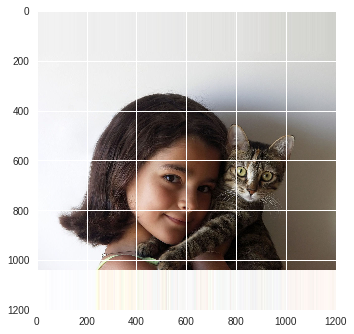

In [3]:
img = cv2.imread('1200px-Girl_and_cat.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = np.pad(img,((158,158),(0,0),(0,0)),mode='edge')
plt.imshow(img)

In [4]:
vgg = keras.applications.vgg16.VGG16(weights='imagenet')

553467904/553467096 [==============================] - 7s 0us/step


In [5]:
def predict(img):
  im = cv2.resize(img,(224,224))
  im = keras.applications.vgg16.preprocess_input(im)
  pr = vgg.predict(np.expand_dims(im,axis=0))[0]
  return np.sum(pr[281:294]) # we know that VGG classes for cats are from 281 to 294

predict(img)

0.61825055

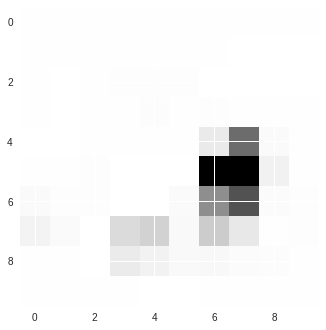

In [6]:
def predict_map(img,n):
  dx = img.shape[0] // n
  res = np.zeros((n,n),dtype=np.float32)
  for i in range(n):
    for j in range(n):
      im = img[dx*i:dx*(i+1),dx*j:dx*(j+1)]
      r = predict(im)
      res[i,j] = r
  return res

plt.imshow(predict_map(img,10))

## Наборы данных для Object Detection

* [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/) - 20 классов
* ImageNet
* [COCO](http://cocodataset.org/#home) - Common Objects in Context. 80 классов, сегментация

![COCO](https://cdn-images-1.medium.com/max/840/1*RKkLHZ2BXkQ_Kf3ZZVBuRQ.png)

## Метрика качества - IoU

Для object detection, нам важна не только метрика правильности определения класса, но и точность локализации объекта. Последняя измеряется с помощью метрики **Intersection over Union** (IoU).

![IoU](https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png)

В качестве решений рассматривают только такие регионы, которые дают значение IoU больше некоторой пороговой величины.

### Mean Average Precision - mAP

Основная метрика для Object Detection - это mAP. Она вычисляется следующим образом:

* Устанавливается некоторое пороговое значение *IoU*
* 

## Подходы к Object Detection

* **Region Proposal Networks** (R-CNN, Fast R-CNN, Faster R-CNN). Основная идея - сгенерировать *ROI* (Regions of Interest) и прогнать CNN на них, максимизируя результат
* **One-pass** (YOLO, RetinaNet). Хитрая архитектура сети, которая сразу обучается предсказывать регионы и вероятность принадлежности классам.

Хорошая статья с описанием методов есть [тут](https://medium.com/comet-app/review-of-deep-learning-algorithms-for-object-detection-c1f3d437b852)

### R-CNN: Region-Based CNN

[R-CNN](http://islab.ulsan.ac.kr/files/announcement/513/rcnn_pami.pdf) использует метод [Selective Search](http://www.huppelen.nl/publications/selectiveSearchDraft.pdf) для генерации иерархической структуры из регионов ROI, к которым затем применяется классификационная CNN (свёрточные слои) с последующими SVM-классификаторами и линейной регрессией для уточнения координат *bounding box*.

![RCNN](https://cdn-images-1.medium.com/max/840/1*JCTKABvEOLBTZsfT85Q2AQ.png)

![RCNN-1](https://cdn-images-1.medium.com/max/840/1*RUjYe8yqo7nKAG2lNd2mbw.png)

### F-RCNN - Fast R-CNN

Подход аналогичен CNN, но регионы выделаются уже после вычисления свёрточного слоя.

![FRCNN](https://cdn-images-1.medium.com/max/840/1*U95lm-Jkwkpy3p8X6IOKlQ.png)

[Статья](https://arxiv.org/pdf/1504.08083.pdf), 2015

### Faster R-CNN

Основная идея алгоритма - использовать нейросеть для предсказания регионов (*Region Proposal Network*). [Статья](https://arxiv.org/pdf/1506.01497.pdf), 2016

![FasterRCNN](https://cdn-images-1.medium.com/max/840/0*HlLHTPDyaJZHLnSl.png)

### R-FCN: Region-Based Fully Convolutional Network

Основная идея - после выделения фич верхнего уровня с помощью ResNet-101, они подаются на вход **Position-Sensitive Score Map**. Каждый объект из $C$ классов разбивается на $k\times k$ регионов, и мы учимся распознавать части объектов. В результате для каждого класса происходит "голосование" всех участков в карте $k\times k$ и принимается решение, есть ли объект на изображении в данном месте.

Примерно на порядок быстрее Faster R-CNN.

![](https://cdn-images-1.medium.com/max/840/1*JFtFIzpDhb3KsN1jran6yA.png)

### YOLO - You Only Look Once

 * [Статья](https://arxiv.org/pdf/1506.02640.pdf), 2016 г.
 * [Сайт](https://pjreddie.com/darknet/yolo/) и авторская реализация на C++ (*darknet*)
 * Yolo: [Реализация на Keras](https://github.com/experiencor/keras-yolo2), [объясняющий notebook](https://github.com/experiencor/basic-yolo-keras/blob/master/Yolo%20Step-by-Step.ipynb)
 * Yolo v2: [Реализация на Keras](https://github.com/experiencor/keras-yolo2), [объясняющий notebook](https://github.com/experiencor/keras-yolo2/blob/master/Yolo%20Step-by-Step.ipynb)
 
 YOLO - однопроходный алгоритм, работающий в реальном времени. Основная идея:
 
 * Изображение разбивается на $S\times S$ регионов
 * Для каждого региона $CNN$ предсказывает $n$ возможных объектов, координаты *bounding box* и *confidence*=*probability* * IoU.
 
 ![](https://cdn-images-1.medium.com/max/840/1*n09xW-miKM_0M62a8VsVjw.png)

### Другие современные алгоритмы

* RetinaNet () 
* U-Net ()
* Mask R-CNN ([статья](https://arxiv.org/abs/1703.06870))

### Практические фреймворки

* [Tensorflow Object Detection](https://github.com/tensorflow/models/tree/master/research/object_detection)
* [Detectron](https://github.com/facebookresearch/Detectron) - Facebook Object Detection Framework
* [SqueezeDet on Keras](https://github.com/omni-us/squeezedet-keras)


## Подготовка изображений для Object Detection

**VOTT** - [Visual Object Tagging Tool](https://github.com/Microsoft/VoTT)

![](https://raw.githubusercontent.com/Microsoft/VoTT/master/media/detectioninabox.jpg)